<a href="https://colab.research.google.com/github/ekasetyo090/youtube-vtuber-analysis/blob/main/Vtuber_Analysis%20colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis Vtuber Indonesia.

In [ ]:
# @title
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import json
import sys
import os
import re

from dotenv import load_dotenv
load_dotenv()
from datetime import datetime
from datetime import timedelta
# pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

def construc_watch_history(dataset):
    data_frame = []
    for i in range(len(dataset)):
        if dataset[i].get('activityControls')[0] == 'YouTube watch history':
            tmp = {}
            tmp['video_title'] = dataset[i].get('title')
            if tmp['video_title'] != None:
                tmp['video_title'] = tmp.get('video_title').removeprefix("Watched ")
            tmp['video_id'] = dataset[i].get('titleUrl')
            if tmp['video_id'] != None:
                tmp['video_id'] = tmp.get('video_id').removeprefix("https://www.youtube.com/watch?v=")
            tmp['channel_url'] = dataset[i].get('subtitles',None)#[0].get('url')
            # if tmp['channel_url'] != None:
            #     if 'url' in tmp['channel_id'][0].keys():
            #         tmp['channel_id'] = tmp['channel_id'][0].get('url').removeprefix("https://www.youtube.com/channel/")
            #     else:
            #         tmp['channel_id'] = None
            tmp['date_watch'] = dataset[i].get('time')
            if tmp['date_watch'] != None:
                if '.' in tmp['date_watch']:  # Check for fractional seconds
                    tmp['date_watch'] = datetime.strptime(tmp['date_watch'], '%Y-%m-%dT%H:%M:%S.%fZ')
                else:
                    tmp['date_watch'] = datetime.strptime(tmp['date_watch'], '%Y-%m-%dT%H:%M:%SZ')
            tmp['products'] = dataset[i].get('products')
            if len(tmp['products']) > 0:
                tmp['products'] = tmp['products'][0]
            data_frame.append(tmp)
    return pd.DataFrame.from_records(data_frame)

def is_watch_video(df1, df2,target:str,result:str):
    df1[result] = False  # Inisialisasi dengan False
    for idx in df1.index:
        # Filter video_id dari df2 yang date_watch-nya kurang dari time_recorded dari df1
        tmp = df2[target].loc[df2['date_watch'] < df1['time_recorded'].iat[idx]]

        # Periksa apakah video_id di df1 ada di tmp
        df1[result].iat[idx] = df1[target].iat[idx] in tmp.values

    return df1[result]

def preprocess_conditions_df(df):
    df['title_contain_keyword'] = df['video_title'].str.contains('vtuber',case=False,regex=False)
    df['desc_contain_keyword'] = df['description'].str.contains('vtuber',case=False,regex=False)
    df['tag_contain_keyword'] = df['video_tag'].str.contains('vtuber',case=False,regex=False)
    df['channel_name_contain_keyword'] = df['channel_title'].str.contains('vtuber',case=False,regex=False)


    # Replace NaN values with False (without inplace) and calculate the number of elements containing 'vtuber'
    df['title_contain_keyword'] = df['title_contain_keyword'].fillna(False)
    df['desc_contain_keyword'] = df['desc_contain_keyword'].fillna(False)
    df['tag_contain_keyword'] = df['tag_contain_keyword'].fillna(False)
    df['channel_name_contain_keyword'] = df['channel_name_contain_keyword'].fillna(False)

    df['number_element_conttain_vtuber'] = (
        df['title_contain_keyword'].astype(int) +
        df['desc_contain_keyword'].astype(int) +
        df['tag_contain_keyword'].astype(int) +
        df['channel_name_contain_keyword'].astype(int)
    )

    df['title_contain_keyword'] = df['title_contain_keyword'].apply(lambda x: 'Title contain keyword' if x else 'Title not contain keyword')
    df['tag_contain_keyword'] = df['tag_contain_keyword'].apply(lambda x: 'Video tag contain keyword' if x else 'Video tag not contain keyword')
    df['desc_contain_keyword'] = df['desc_contain_keyword'].apply(lambda x: 'Describtions contain keyword' if x else 'Describtions not contain keyword')
    df['channel_name_contain_keyword'] = df['channel_name_contain_keyword'].apply(lambda x: 'Channel name contain keyword' if x else 'Channel name not contain keyword')
    df['Conditions'] = df['channel_name_contain_keyword']+' ,'+df['title_contain_keyword']+' ,'+df['desc_contain_keyword']+' ,'+df['tag_contain_keyword']
    return df

def diff_data(data:pd.DataFrame,target:str,result:str)->pd.DataFrame:
    data = data.sort_values(by=['video_id', 'time_recorded'])
    data[result] = None  # Inisialisasi kolom views_changing
    for video_id, group in data.groupby('video_id'):
        # Melakukan perhitungan diff() pada setiap grup video_id
        data.loc[group.index, result] = group[target].diff(1)
    return data

df_yt_search = pd.read_csv('data/google trends/multiTimeline.csv')
df_yt_search['Minggu'] = pd.to_datetime(df_yt_search['Minggu'])

hari_kategori = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_yt_search_day = pd.read_csv('data/google trends/multiTimeline_day.csv')
df_yt_search_day.rename(columns={'Hari': 'Tanggal'}, inplace=True)
df_yt_search_day['Tanggal'] = pd.to_datetime(df_yt_search_day['Tanggal'])
df_yt_search_day['Hari'] = df_yt_search_day['Tanggal'].dt.day_name()
df_yt_search_day['Hari'] = pd.Categorical(df_yt_search_day['Hari'], categories=hari_kategori, ordered=True)

df_yt_search7 = pd.read_csv('data/google trends/multiTimeline7.csv')
df_yt_search7['Waktu'] = pd.to_datetime(df_yt_search7['Waktu'])
df_yt_search7['Pukul'] = df_yt_search7['Waktu'].dt.time

df_vtuber_growth = pd.read_csv('data/youtube_scraping/vtuber_debut_clean.csv')
df_vtuber_growth['date']=pd.to_datetime(df_vtuber_growth['video_start_time(UTC)']).dt.to_period('M').dt.to_timestamp()

df_video = pd.read_csv('data/youtube_scraping/video.csv')
df_video['time_recorded'] = pd.to_datetime(df_video['time_recorded'], format='%Y-%m-%d %H:%M:%S.%f')  # Specify format if needed
df_video['time_recorded'] = df_video['time_recorded'].dt.tz_localize('Asia/Jakarta').dt.tz_convert('UTC')

# df_video['time_recorded'] = pd.to_datetime(df_video['time_recorded'],dayfirst=True).tz_localize('Asia/Jakarta')
with open(os.getenv('yt_watch_history'), 'r',encoding='ISO-8859-1') as file:
    data = json.load(file)
df_watch = construc_watch_history(data)
df_watch['date_watch'] = df_watch['date_watch'].dt.tz_localize('UTC')
df_watch = df_watch.loc[df_watch['date_watch']<=df_video['time_recorded'].max()]
df_watch['channel_id']=df_watch['channel_url'].apply(lambda x: x[0].get('url')if x is not None else None)
df_watch['channel_id'] = df_watch['channel_id'].apply(lambda x: x.removeprefix("https://www.youtube.com/channel/") if x is not None and len(x) > 0 else None)

df_video['is_watch_video'] = is_watch_video(df_video,df_watch,target='video_id',result='is_watch_video')
df_video['is_watch_channel'] = is_watch_video(df_video,df_watch,target='channel_id',result='is_watch_channel')
df_subs = pd.read_csv(os.getenv('yt_subscribtions'))

df_video['is_subscribe_channel'] = df_video['channel_id'].isin(df_subs['Channel Id'])
df_video = preprocess_conditions_df(df_video)
del data,df_watch,df_subs

df_video_track = pd.read_csv('data/youtube_scraping/video_reserve.csv')
df_video_track['time_recorded'] = pd.to_datetime(df_video_track['time_recorded'], format='%Y-%m-%d %H:%M:%S.%f')  # Specify format if needed
df_video_track['time_recorded'] = df_video_track['time_recorded'].dt.tz_localize('Asia/Jakarta').dt.tz_convert('UTC')
# df_video_track['time_recorded'] = pd.to_datetime(df_video_track['time_recorded'],dayfirst=True).tz_localize('Asia/Jakarta')
df_video_track = diff_data(
    data=df_video_track,
    target='view_count',
    result='views_changing')
df_video_track = diff_data(
    data=df_video_track,
    target='like_count',
    result='like_changing')

C:\Users\snsv\AppData\Local\Temp\ipykernel_13744\2583168038.py:108: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_vtuber_growth['date']=pd.to_datetime(df_vtuber_growth['video_start_time(UTC)']).dt.to_period('M').dt.to_timestamp()
C:\Users\snsv\AppData\Local\Temp\ipykernel_13744\2583168038.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['desc_contain_keyword'] = df['desc_contain_keyword'].fillna(False)
C:\Users\snsv\AppData\Local\Temp\ipykernel_13744\2583168038.py:68: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downca

## Pendahuluan

Notebook ini bertujuan untuk memahami bagaimana skenario penggunaan keyword vtuber, pentumbuhan kompetisi pasar, dan volume pencarian.


## Penjelasan Data
 - data volume pencarian berasal dari google trends.
 - data pertumbuhan vtuber berasal dari menggunakan api https://github.com/ekasetyo090/YT_Scrapy, dengan kueri "debut stream vtuber" dan di verifikasi secara manual.
 - data pencarian "live" vtuber hasil pencarian pada akun personal dengan interval 5 menit sebanyak n-kali.



## Apa itu 'VTUBER'
VTuber merujuk kepada para pembuat konten online yang memanfaatkan avatar digital sebagai representasi dalam dunia maya. Dalam konteks ini, VTuber memiliki kecenderungan kuat untuk lebih mengandalkan avatar digital ketimbang mengungkapkan penampilan fisik asli.
Para VTuber seringkali merancang karakter virtual dengan cermat, menambahkan elemen-elemen unik, seperti latar belakang cerita, kepribadian, dan bahkan kemampuan khusus. Dalam prosesnya, VTuber menciptakan koneksi kuat dengan penggemar, yang tertarik pada karakter virtual dan konten yang disampaikan.
Para VTuber sering menghadirkan beragam jenis konten, mulai dari bermain video game, bernyanyi, hingga berbicara tentang berbagai topik. Mereka menjalin hubungan dekat dengan komunitas dan merespons permintaan serta preferensi penggemar. Dengan demikian, VTuber menciptakan konten relevan dan menghibur yang menghubungkan dengan audiens setia.

## Volume Pencarian 'VTUBER' pada youtube

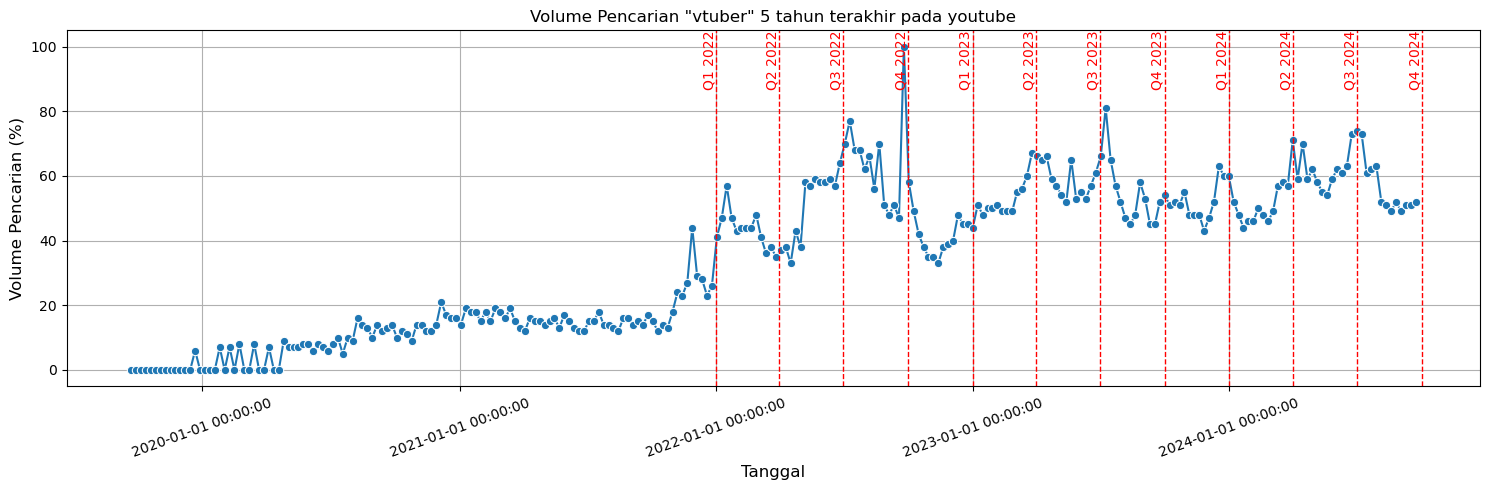

In [ ]:
# @title
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df_yt_search,x='Minggu',y='vtuber: (Indonesia)',ax=ax,marker='o')
ax.set_ylabel('Volume Pencarian (%)', fontsize=12, rotation=90)
ax.set_xlabel('Tanggal', fontsize=12)
ax.set_title('Volume Pencarian "vtuber" 5 tahun terakhir pada youtube')
ax.tick_params(axis='x', rotation=20)
ax.grid(True)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

quarters_2022 = [
    '2022-01-01', '2022-04-01', '2022-07-01', '2022-10-01',
    '2023-01-01', '2023-04-01', '2023-07-01', '2023-10-01',
    '2024-01-01', '2024-04-01', '2024-07-01', '2024-10-01',
]
quarter_labels = [
    'Q1 2022', 'Q2 2022', 'Q3 2022', 'Q4 2022',
    'Q1 2023', 'Q2 2023', 'Q3 2023', 'Q4 2023',
    'Q1 2024', 'Q2 2024', 'Q3 2024', 'Q4 2024',
]

for quarter, label in zip(quarters_2022, quarter_labels):
    date = pd.to_datetime(quarter)
    ax.axvline(date, color='red', linestyle='--', linewidth=1)
    ax.text(date, ax.get_ylim()[1], label, color='red', fontsize=10, rotation=90,
            verticalalignment='top', horizontalalignment='right')
plt.tight_layout()
plt.show()

Volume pencarian kata kunci 'vtuber' cenderung stabil sejak 1 januari 2023 dengan rentang volume antara 40-80% dari volume tertingginya (100%) antara Q3 2022. pada Q3 tahun 2022-2024 cenderung mengalami penurunan volume hal ini berkorelasi dengan jadwal assesment nasional (AN) dan ujian semester untuk SD/SMP/SMA.

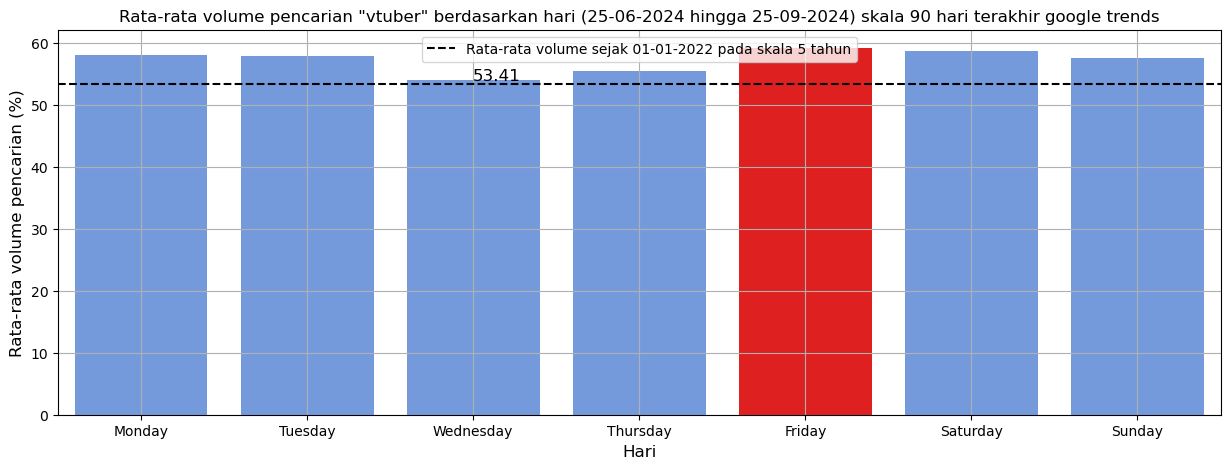

In [ ]:
# @title

fifth_year_mean = df_yt_search['vtuber: (Indonesia)'].loc[df_yt_search['Minggu'] > '2022-01-01'].mean()


df_grouped = df_yt_search_day.groupby(df_yt_search_day['Hari'], observed=False)['vtuber: (Indonesia)'].mean().reset_index()

max_value = df_grouped['vtuber: (Indonesia)'].max()
colors = ['red' if value == max_value else 'cornflowerblue' for value in df_grouped['vtuber: (Indonesia)']]


fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df_grouped,x='Hari',y='vtuber: (Indonesia)',ax=ax,palette=colors,hue='Hari')
ax.axhline(fifth_year_mean, color='black', linestyle='--', label=f'Rata-rata volume sejak 01-01-2022 pada skala 5 tahun')
ax.text(x=2,
        y=fifth_year_mean + 0.5,
        s=f'{fifth_year_mean:.2f}',
        color='black',
        fontsize=12)

ax.set_ylabel('Rata-rata volume pencarian (%)', fontsize=12, rotation=90)
ax.set_xlabel('Hari', fontsize=12)
ax.set_title('Rata-rata volume pencarian "vtuber" berdasarkan hari (25-06-2024 hingga 25-09-2024) skala 90 hari terakhir google trends')
ax.tick_params(axis='x', rotation=0)
ax.grid(True)
plt.legend()

Volume pencarian kata kunci 'vtuber' pada rentang (25-06-2024 hingga 25-09-2024) cenderung sama dan memiliki volume diatas rata-rata (sejak 01-01-2022), pada hari jumat memiliki rata-rata volume pencarian tertinggi dibandung hari yang lainnya.

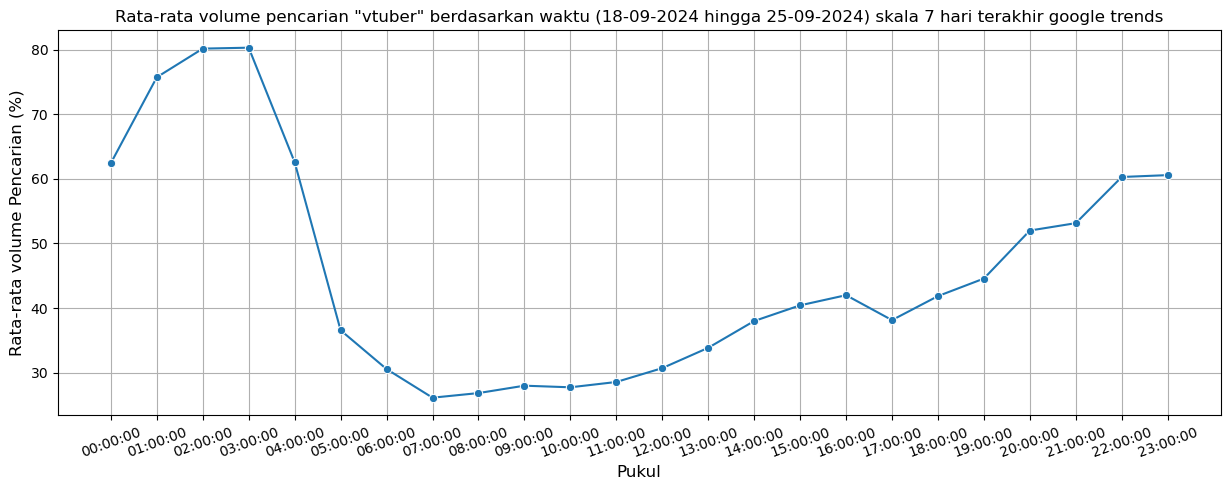

In [ ]:
# @title
df_grouped = df_yt_search7.groupby(df_yt_search7['Pukul'].astype(str))['vtuber: (Indonesia)'].mean().reset_index()
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df_grouped,x='Pukul',y='vtuber: (Indonesia)',ax=ax,marker='o')
ax.set_ylabel('Rata-rata volume Pencarian (%)', fontsize=12, rotation=90)
ax.set_xlabel('Pukul', fontsize=12)
ax.set_title('Rata-rata volume pencarian "vtuber" berdasarkan waktu (18-09-2024 hingga 25-09-2024) skala 7 hari terakhir google trends')
ax.tick_params(axis='x', rotation=20)
ax.grid(True)

Volume pencarian turun signifikan sejak pukul 3 pagi hingga pukul 7 pagi kemudian naik perlahan hingga pukul 12 malam kemudian terjadi lonjakan kenaikan hingga pukul 2 pagi. maka waktu terbaik untuk melakukan streaming menggunakan kata kunci 'vtuber' dimulai pukul 6 sore hingga pukul 2 pagi.

## Geografi riwayat pada google trend

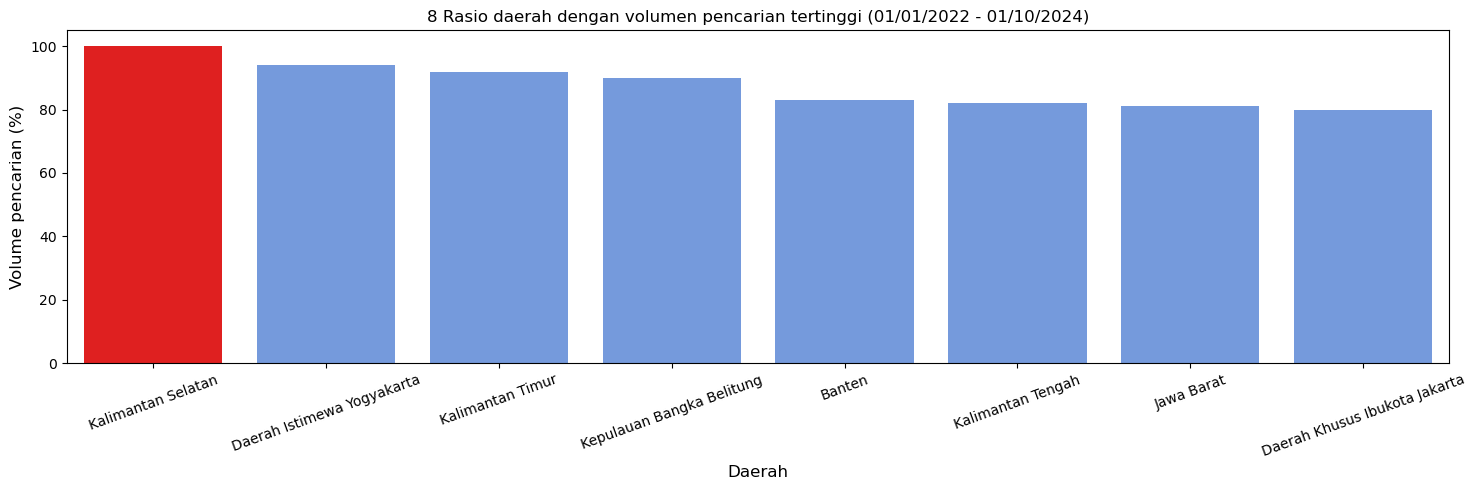

In [ ]:
# @title
df_geo = pd.read_csv('data/google trends/geoMap.csv')
tmp = df_geo.iloc[:8]
max_value = df_geo['vtuber: (01/01/22 - 01/10/24)'].max()
colors = ['red' if value == max_value else 'cornflowerblue' for value in tmp['vtuber: (01/01/22 - 01/10/24)']]
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=tmp,x='Wilayah',y='vtuber: (01/01/22 - 01/10/24)',ax=ax,palette=colors,hue='Wilayah')
ax.set_ylabel('Volume pencarian (%)', fontsize=12, rotation=90)
ax.set_xlabel('Daerah', fontsize=12)
ax.set_title('8 Rasio daerah dengan volumen pencarian tertinggi (01/01/2022 - 01/10/2024)')
ax.tick_params(axis='x', rotation=20)
plt.tight_layout()
plt.show()

kalimantan selatan merupakan daerah mayoritas asal pencarian kata kunci 'vtuber' pada youtube dengan rasio 100%.

## Pertumbuhan vtuber yang melakukan debut

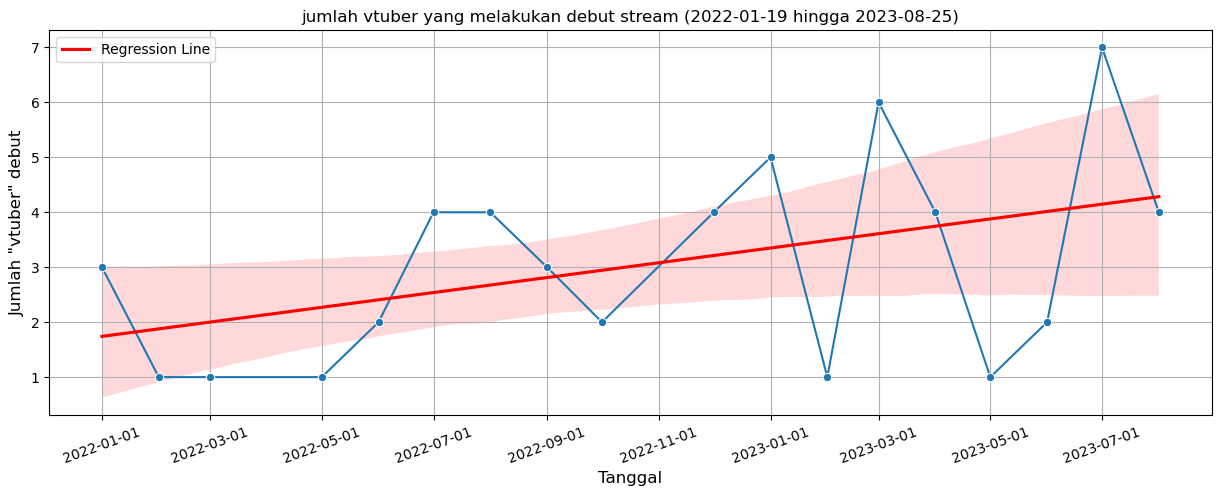

In [ ]:
# @title

vtuber_count = df_vtuber_growth[df_vtuber_growth['is_vtuber'] == True].groupby('date')['is_vtuber'].count()

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=vtuber_count.index,y=vtuber_count.values,ax=ax,marker='o')
sns.regplot(x=mdates.date2num(vtuber_count.index), y=vtuber_count.values, scatter=False, ax=ax, color='r', label='Garis regresi')

plt.legend()
ax.set_ylabel('Jumlah "vtuber" debut', fontsize=12, rotation=90)
ax.set_xlabel('Tanggal', fontsize=12)
ax.set_title('jumlah vtuber yang melakukan debut stream (2022-01-19 hingga 2023-08-25) mengalami tren peningkatan')
ax.tick_params(axis='x', rotation=20)
ax.grid(True)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

Hal ini menjadikan persaingan vtuber menjadi semakin ketat dari waktu ke waktu

## Hasil pencarian live "vtuber"
hasil pencarian pada youtube menggunakan device laptop menunjukkan tampilan pertama yang dilihat user adalah peringkat 1 dan 2.
<img src="data/image/search_result.png" height="110%">

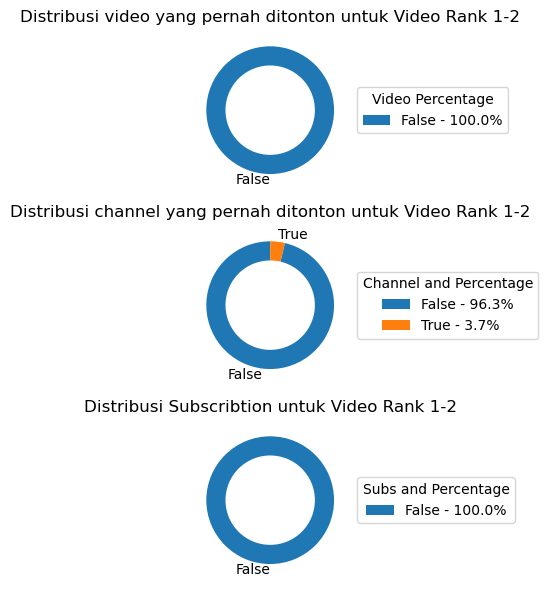

In [ ]:
# @title


tmp = df_video.loc[df_video['video_rank']<=2]
video_ids = tmp['video_id'].unique()
tmp_list = []
for id in video_ids:
    tmp_list.append(tmp.loc[tmp['video_id']==id].iloc[0])
tmp = pd.DataFrame.from_records(tmp_list)
counts_video = tmp['is_watch_video'].value_counts()
counts_channel = tmp['is_watch_channel'].value_counts()
counts_subs = tmp['is_subscribe_channel'].value_counts()

fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(12, 6))

# Plot 1st
wedges1, texts1 = ax1.pie(counts_video, labels=counts_video.index, autopct=None, startangle=90, wedgeprops={'width': 0.3})
labels1 = [f'{label} - {round(100*count/sum(counts_video), 1)}%' for label, count in zip(counts_video.index, counts_video)]
ax1.legend(wedges1, labels1, title="Video Percentage", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax1.set_title('Distribusi video yang pernah ditonton untuk Video Rank 1-2')

# Plot the 2nd
wedges2, texts2 = ax2.pie(counts_channel, labels=counts_channel.index, autopct=None, startangle=90, wedgeprops={'width': 0.3})
labels2 = [f'{label} - {round(100*count/sum(counts_channel), 1)}%' for label, count in zip(counts_channel.index, counts_channel)]
ax2.legend(wedges2, labels2, title="Channel and Percentage", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax2.set_title('Distribusi channel yang pernah ditonton untuk Video Rank 1-2')
# plot for 3rd
wedges3, texts3 = ax3.pie(counts_subs, labels=counts_subs.index, autopct=None, startangle=90, wedgeprops={'width': 0.3})
labels3 = [f'{label} - {round(100*count/sum(counts_subs), 1)}%' for label, count in zip(counts_subs.index, counts_subs)]
ax3.legend(wedges3, labels3, title="Subs and Percentage", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax3.set_title('Distribusi Subscribtion untuk Video Rank 1-2')


plt.tight_layout()
plt.show()

Dari seluruh populasi sangat sedikit hasil pencarian yang berasal dari video yang pernah ditonton ataupun dari channel yang pernah ditonton.

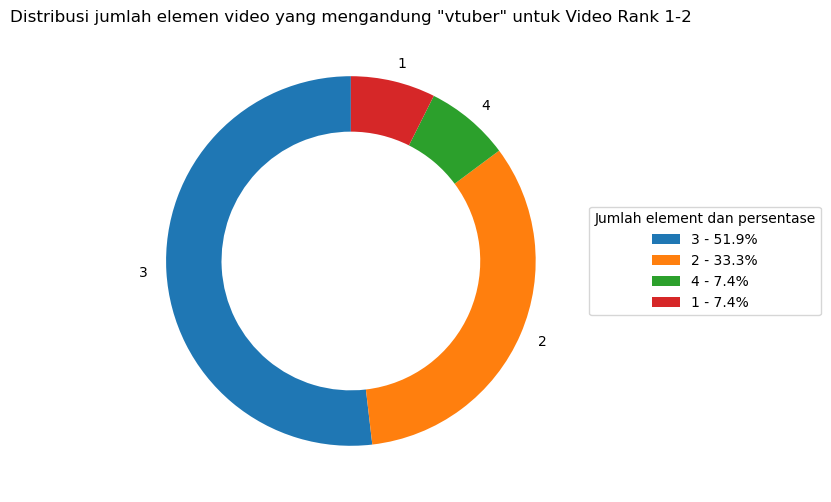

In [ ]:
# @title
video_ids = df_video['video_id'].loc[df_video['video_rank']<=2].unique()
tmp_data = []
for id in video_ids:
    tmp_data.append(df_video.loc[df_video['video_id']==id].iloc[0])
tmp_data = pd.DataFrame.from_records(tmp_data)
counts = tmp_data['number_element_conttain_vtuber'].value_counts()

plt.figure(figsize=(8, 6))
wedges, texts= plt.pie(counts, labels=counts.index, autopct=None, startangle=90, wedgeprops={'width': 0.3})
labels = [f'{label} - {round(100*count/sum(counts), 1)}%' for label, count in zip(counts.index, counts)]
plt.legend(wedges, labels, title="Jumlah element dan persentase", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Distribusi jumlah elemen video yang mengandung "vtuber" untuk Video Rank 1-2')
plt.show()


Komposisi jumlah elemen (nama channel, judul video, deskripsi video, dan tag video) yang mengandung 'vtuber' didominasi oleh 3 elemen untuk peringkat 1-2.


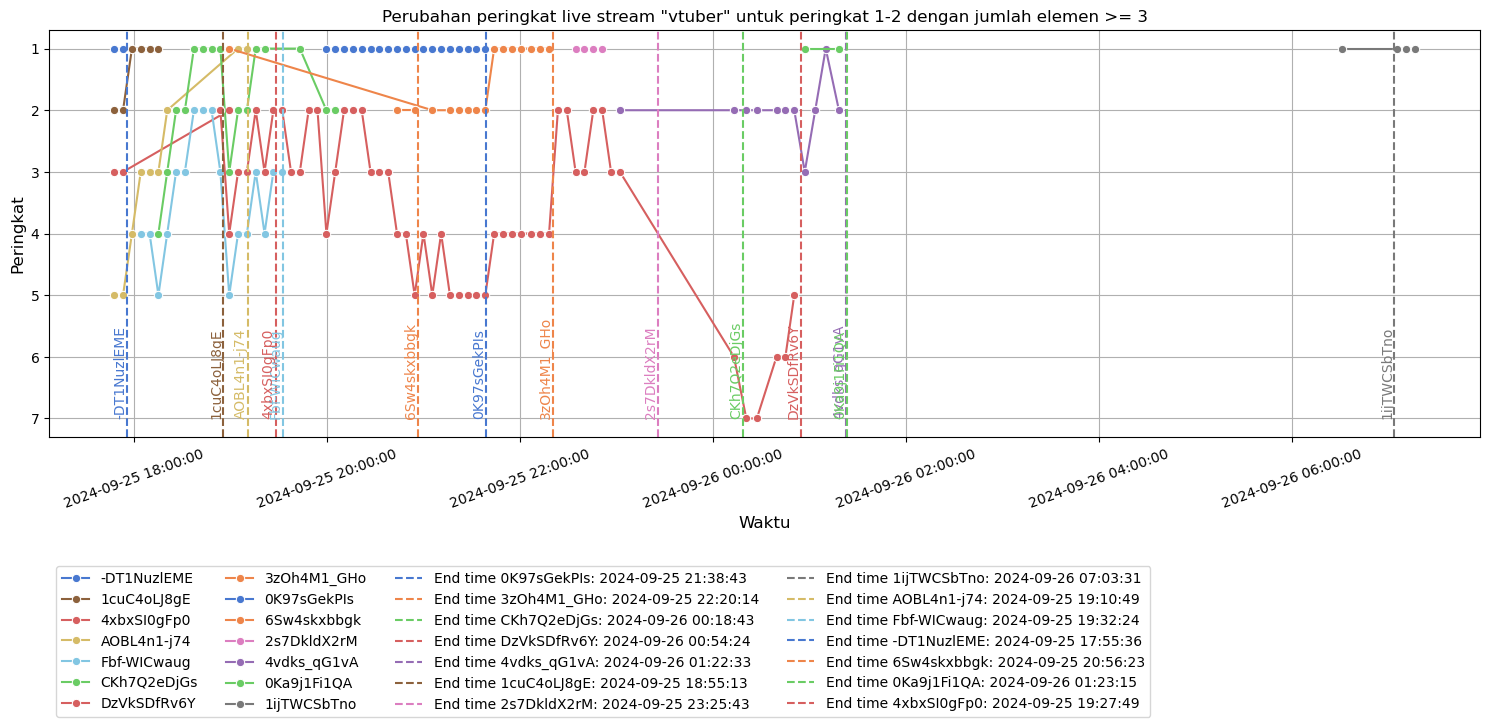

In [ ]:
tmp_data = df_video.loc[(df_video['video_rank']<=2) & (df_video['number_element_conttain_vtuber']>=3)]
video_ids = tmp_data['video_id'].value_counts().index
end_time_dict = {}
new_vid_id = []
for video_id in video_ids:

    video_data = df_video_track.loc[(df_video_track['video_id'] == video_id)&(df_video_track['duration(s)']>0)]
    if video_data.shape[0]>0:
        video_data = video_data.iloc[0]
        start_time = pd.to_datetime(video_data['start_time(UTC)']).timestamp()


        end_time = start_time + video_data['duration(s)']
        end_time = pd.to_datetime(end_time, unit='s')
        end_time_dict[video_id] = end_time
        new_vid_id.append(video_id)
        del start_time,end_time
    del video_data


palette = sns.color_palette("muted", len(new_vid_id))
video_id_palette = {video_id: palette[i] for i, video_id in enumerate(new_vid_id)}

fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(data=df_video.loc[df_video['video_id'].isin(new_vid_id)],
             x='time_recorded',
             y='video_rank',
             hue='video_id',
             ax=ax,marker='o',
             palette=video_id_palette)

ax.set_ylabel('Peringkat', fontsize=12, rotation=90)
ax.set_xlabel('Waktu', fontsize=12)
ax.set_title('Perubahan peringkat live stream "vtuber" untuk peringkat 1-2 dengan jumlah elemen >= 3')
ax.tick_params(axis='x', rotation=20)
ax.invert_yaxis()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

for video_id, end_time in end_time_dict.items():
    ax.axvline(x=end_time, color=video_id_palette[video_id], linestyle='--', label=f'End time {video_id}: {end_time}')
    ax.text(end_time, 7, video_id, color=video_id_palette[video_id],
            fontsize=10, rotation=90,
            verticalalignment='bottom',
            horizontalalignment='right',
            # y=7
           )

ax.grid(True)

handles, labels = ax.get_legend_handles_labels()
plt.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(0, -0.3), ncol=4)
plt.tight_layout()
plt.show()

Perubahan peringkat diberikan berdasarkan relevasi livestream terhadap "vtuber", apabila livestream 'A' telah selesai maka video tersebut akan digantikan oleh video 'B' dengan peringkat relevansi dibawahnya. apabila ketika livestream 'A' belum selesai tetapi livestream 'B' yang baru saja dimulai memiliki relevansi yang lebih tinggi dibanding 'A', makan 'B' akan menggeser peringkat 'A'.

## Faktor yang mempengaruhi relevansi

In [ ]:
# @title
tmp = df_video.loc[(df_video['video_id']=='CKh7Q2eDjGs')&(df_video['video_rank']==1)].reset_index(drop=True)
max_date = tmp['time_recorded'].max()
tmp = df_video.loc[(df_video['time_recorded']==max_date)]
video_ids = tmp['video_id'].unique()
text_key = ['channel_title','video_title','description','video_tag']
tmp_dict = {}
for key in tmp.keys():
    if key in ['video_rank','video_id']:
        continue
    if key not in text_key:
        print(f'\n----------{key}----------')
        for id in video_ids:
            tmp = df_video.loc[(df_video['video_id']==id)&(df_video['time_recorded']==max_date)].iloc[0]
            print(f"Peringkat {tmp.get('video_rank')}: {tmp.get('video_id')} = {tmp.get(key)}")
    else:
        print(f'\n----------{key}----------')
        for id in video_ids:

            tmp = df_video.loc[(df_video['video_id']==id)&(df_video['time_recorded']==max_date)].iloc[0]
            tmp[key] = str(tmp.get(key))
            tmp_data =re.findall(r'\bvtuber\w*\b', tmp.get(key), re.IGNORECASE)
            print(f"Peringkat {tmp.get('video_rank')}: {tmp.get('video_id')}  'vtuber' count = {len(tmp_data)}")
            if id not in tmp_dict.keys():
                tmp_dict[id] = len(tmp_data)
            else:
                tmp_dict[id] += len(tmp_data)
print('\n----------Jumlah "vtuber" diseluruh elemen----------')
for key in tmp_dict.keys():
    tmp = df_video.loc[(df_video['video_id']==key)&(df_video['time_recorded']==max_date)].iloc[0]
    print(f"Peringkat {tmp.get('video_rank')}: {tmp.get('video_id')} = {tmp_dict.get(key)}")



----------published_date----------
Peringkat 1: CKh7Q2eDjGs = 2024-09-25 16:00:57+00:00
Peringkat 2: DA5gdU9CVMA = 2024-09-25 14:54:27+00:00
Peringkat 3: DzVkSDfRv6Y = 2024-09-25 18:44:56+00:00
Peringkat 4: EhMH_ZrLfsE = 2024-09-25 14:12:48+00:00
Peringkat 5: I6XqA2rvn7k = 2024-09-23 18:37:10+00:00
Peringkat 6: KXlgfN_KKx8 = 2024-09-25 11:40:32+00:00
Peringkat 7: NEm92SDzXo0 = 2024-09-25 17:58:21+00:00
Peringkat 8: RqBKFkLfX08 = 2024-09-25 18:02:51+00:00
Peringkat 9: TCuJkrcpMxg = 2024-09-25 17:01:35+00:00
Peringkat 10: URmVinmP5gI = 2024-09-25 18:30:33+00:00
Peringkat 11: V-23knZ_WwM = 2024-09-25 18:38:02+00:00
Peringkat 12: Wfa2en56HzU = 2024-09-25 17:01:49+00:00
Peringkat 13: WgwhX3pHLzw = 2024-09-25 17:46:26+00:00
Peringkat 14: bqnFFlVr3RA = 2024-09-25 18:42:33+00:00
Peringkat 15: bw_rDMdgehg = 2024-09-25 16:16:34+00:00
Peringkat 16: fLVvnGPLeXs = 2023-12-23 11:54:33+00:00
Peringkat 17: hh7e81_HcLE = 2024-09-25 10:39:11+00:00
Peringkat 18: sM8pBnZ3bzg = 2024-09-25 18:15:31+00:00
P

Tidak ada hal yang dapat digunakan sebagai acuan pasti untuk meningkatkan relevansi, kemungkinan besar relevansi dihitung berdasarkan asosiasi/kemiripan 'perilaku' penonton yang mencari 'vtuber' dengan riwayat hasil pencarian 'vtuber' sebelumnya,

## Kesimpulan
- Persaingan pasar 'vtuber' semakin ketat.
- Baiknya konten menyesuaikan geografi dan demografi asal pencari 'vtuber'.
- Jumlah elemen yang mengandung 'vtuber' tidak mempengaruhi relevansi secara langsung, meskinpun demikian setidaknya ada 1 elemen yang mengandung 'vtuber' agar algoritma relevansi youtube secara efektif mengenali target pasar livestream tersebut.
- Menaikan 'viewer retention' dan 'views' agar dapat secara signifikan menaikan peringkat relevansi.